# Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
RANDOM_SEED = 123 
LABELS = ["Not Anomaly","Anomaly"]


# Read Data

In [2]:
# dfcpu = pd.read_csv('../data/processed/cpu4.csv')
dfcpu = pd.read_csv('https://raw.githubusercontent.com/ChetanaRajabhoj/kagglex-project/main/data/processed/cpu4.csv')

In [3]:
dfcpu.columns

Index(['datetime', 'timestamp', 'value', 'label', 'date', 'time', 'month',
       'day', 'hour', 'minute', 'value(t-1)', 'value(t-2)', 'value(t-3)',
       'value(t-4)', 'value(t-5)', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'hour.1', 'hour_sin', 'hour_cos'],
      dtype='object')

In [4]:
print(dfcpu.label.value_counts(), "\n","--------------------------")
print("in percentage", "\n", "--------------------------")
print(dfcpu.label.value_counts(normalize=True))

0    17359
1      209
Name: label, dtype: int64 
 --------------------------
in percentage 
 --------------------------
0    0.988103
1    0.011897
Name: label, dtype: float64


# Model 1 - Time Variables encoded using sine/cosine transformation

In [5]:
columnlist = [ 'datetime','value', 'hour_sin', 'hour_cos', 'label']
data = dfcpu[columnlist].copy().set_index('datetime')
data

,value,hour_sin,hour_cos,label
datetime,,,,
2016-07-24 16:00:00,0.847300,-0.866025,-0.500000,0
2016-07-24 16:05:00,-0.036137,-0.866025,-0.500000,0
2016-07-24 16:10:00,0.074292,-0.866025,-0.500000,0
2016-07-24 16:15:00,0.074292,-0.866025,-0.500000,0
2016-07-24 16:20:00,-0.036137,-0.866025,-0.500000,0
...,...,...,...,...
2016-09-23 15:35:00,0.074292,-0.707107,-0.707107,0
2016-09-23 15:40:00,0.295152,-0.707107,-0.707107,0
2016-09-23 15:45:00,0.074292,-0.707107,-0.707107,0


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['value'] = scaler.fit_transform(data['value'].values.reshape(-1, 1))
data

,value,hour_sin,hour_cos,label
datetime,,,,
2016-07-24 16:00:00,0.450980,-0.866025,-0.500000,0
2016-07-24 16:05:00,0.294118,-0.866025,-0.500000,0
2016-07-24 16:10:00,0.313725,-0.866025,-0.500000,0
2016-07-24 16:15:00,0.313725,-0.866025,-0.500000,0
2016-07-24 16:20:00,0.294118,-0.866025,-0.500000,0
...,...,...,...,...
2016-09-23 15:35:00,0.313725,-0.707107,-0.707107,0
2016-09-23 15:40:00,0.352941,-0.707107,-0.707107,0
2016-09-23 15:45:00,0.313725,-0.707107,-0.707107,0


In [7]:
data.index.min(),data.index.max()

('2016-07-24 16:00:00', '2016-09-23 15:55:00')

## Split Data 

In [8]:
train = data.loc[data.index < '2016-09-01']
test = data.loc[data.index >= '2016-09-01']
print(train.shape, test.shape)
print(train.label.value_counts())
print(test.label.value_counts())

(11040, 4) (6528, 4)
0    10855
1      185
Name: label, dtype: int64
0    6504
1      24
Name: label, dtype: int64


In [9]:
train = train.values
test = test.values
X_train, y_train= train[:,0:-1], train[:,-1]
X_test, y_test= test[:,0:-1], test[:,-1]
X_train.shape, y_train.shape,X_test.shape, y_test.shape

((11040, 3), (11040,), (6528, 3), (6528,))

In [10]:
nb_epoch = 50
batch_size = 64
input_dim = X_train.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2=4  
learning_rate = 1e-7

## Define Model

In [11]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(input_dim, ))
#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh", activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 14)                56        
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 4)                 32        
                                                                 
 dense_3 (Dense)             (None, 7)                 35        
                                                                 
 dropout_1 (Dropout)         (None, 7)                 0     

In [12]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_anomaly_2.h5",mode='min', monitor='val_loss', verbose=2, save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True)

In [13]:
# autoencoder.compile(metrics=['accuracy'],
#                     loss='mean_squared_error',
#                     optimizer='adam')

# autoencoder.compile(optimizer='adam',
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=[tf.keras.metrics.AUC()])

autoencoder.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC(from_logits=True)])

## Fit the Model

In [14]:
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=False,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history

Epoch 1/50
160/173 [==========================>...] - ETA: 0s - loss: 0.6216 - auc: 0.4374
Epoch 1: val_loss improved from inf to 0.55354, saving model to autoencoder_anomaly_2.h5
173/173 [==============================] - 3s 9ms/step - loss: 0.6158 - auc: 0.4385 - val_loss: 0.5535 - val_auc: 0.3620
Epoch 2/50
165/173 [===========================>..] - ETA: 0s - loss: 0.5184 - auc: 0.4819
Epoch 2: val_loss improved from 0.55354 to 0.48612, saving model to autoencoder_anomaly_2.h5
173/173 [==============================] - 1s 5ms/step - loss: 0.5148 - auc: 0.4782 - val_loss: 0.4861 - val_auc: 0.4205
Epoch 3/50
169/173 [============================>.] - ETA: 0s - loss: 0.4670 - auc: 0.4977
Epoch 3: val_loss improved from 0.48612 to 0.45364, saving model to autoencoder_anomaly_2.h5
173/173 [==============================] - 1s 6ms/step - loss: 0.4648 - auc: 0.4938 - val_loss: 0.4536 - val_auc: 0.4679
Epoch 4/50
172/173 [============================>.] - ETA: 0s - loss: 0.4394 - auc: 0.484

## Plot Loss

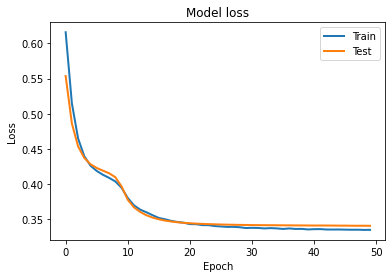

In [15]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

## Plot Reconstruction Error 

In [16]:
X_test_predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})

204/204 [==============================] - 0s 1ms/step


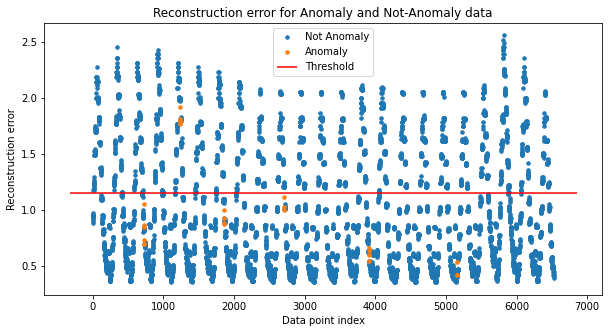

In [17]:
threshold_fixed = 1.15
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(10,5))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Anomaly" if name == 1 else "Not Anomaly")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for Anomaly and Not-Anomaly data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

## Plot Metrics

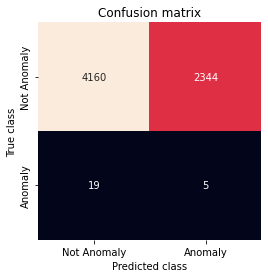

 F1-Score:  0.004214075010535188
 Recall:  0.20833333333333334
 Precision:  0.0021285653469561515


In [18]:
threshold_fixed = 1.14
y_pred = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =y_pred
conf_matrix = confusion_matrix(error_df.True_class, y_pred)
# print(conf_matrix)
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cbar=False);
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" F1-Score: ",metrics.f1_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))

In [19]:
print(error_df.pred.value_counts(), "\n","--------------------------")
print("in percentage", "\n", "--------------------------")
print(error_df.pred.value_counts(normalize=True))

0    4179
1    2349
Name: pred, dtype: int64 
 --------------------------
in percentage 
 --------------------------
0    0.640165
1    0.359835
Name: pred, dtype: float64


# Model 2 - Time Variables encoded using dummy transformation

In [20]:
columnlist = [ 'datetime','value', 
               'hour_1', 'hour_2', 'hour_3', 'hour_4','hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 
               'hour_11','hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17','hour_18', 'hour_19', 'hour_20', 
               'hour_21', 'hour_22', 'hour_23', 'label']
data = dfcpu[columnlist].copy().set_index('datetime')
data

,value,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,label
datetime,,,,,,,,,,,,,,,,,,,,,
2016-07-24 16:00:00,0.847300,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2016-07-24 16:05:00,-0.036137,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2016-07-24 16:10:00,0.074292,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2016-07-24 16:15:00,0.074292,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2016-07-24 16:20:00,-0.036137,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-23 15:35:00,0.074292,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2016-09-23 15:40:00,0.295152,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2016-09-23 15:45:00,0.074292,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['value'] = scaler.fit_transform(data['value'].values.reshape(-1, 1))
data

,value,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,label
datetime,,,,,,,,,,,,,,,,,,,,,
2016-07-24 16:00:00,0.450980,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2016-07-24 16:05:00,0.294118,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2016-07-24 16:10:00,0.313725,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2016-07-24 16:15:00,0.313725,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2016-07-24 16:20:00,0.294118,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-23 15:35:00,0.313725,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2016-09-23 15:40:00,0.352941,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2016-09-23 15:45:00,0.313725,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [22]:
data.index.min(),data.index.max()

('2016-07-24 16:00:00', '2016-09-23 15:55:00')

## Split Data

In [23]:
train = data.loc[data.index < '2016-09-01']
test = data.loc[data.index >= '2016-09-01']
print(train.shape, test.shape)
print(train.label.value_counts())
print(test.label.value_counts())

(11040, 25) (6528, 25)
0    10855
1      185
Name: label, dtype: int64
0    6504
1      24
Name: label, dtype: int64


In [24]:
train = train.values
test = test.values
X_train, y_train= train[:,0:-1], train[:,-1]
X_test, y_test= test[:,0:-1], test[:,-1]
X_train.shape, y_train.shape,X_test.shape, y_test.shape

((11040, 24), (11040,), (6528, 24), (6528,))

## Define Model

In [25]:
nb_epoch = 50
batch_size = 64
input_dim = X_train.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2=4  
learning_rate = 1e-7

In [26]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(input_dim, ))
#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh", activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 dense_6 (Dense)             (None, 14)                350       
                                                                 
 dropout_2 (Dropout)         (None, 14)                0         
                                                                 
 dense_7 (Dense)             (None, 7)                 105       
                                                                 
 dense_8 (Dense)             (None, 4)                 32        
                                                                 
 dense_9 (Dense)             (None, 7)                 35        
                                                                 
 dropout_3 (Dropout)         (None, 7)                 0   

In [27]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_anomaly.h5",mode='min', monitor='val_loss', verbose=2, save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True)

In [28]:
# autoencoder.compile(metrics=['accuracy'],
#                     loss='mean_squared_error',
#                     optimizer='adam')

# autoencoder.compile(optimizer='adam',
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=[tf.keras.metrics.AUC()])

autoencoder.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC(from_logits=True)])

In [29]:
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=False,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history

Epoch 1/50
165/173 [===========================>..] - ETA: 0s - loss: 0.6831 - auc_1: 0.4793
Epoch 1: val_loss improved from inf to 0.67220, saving model to autoencoder_anomaly.h5
173/173 [==============================] - 2s 6ms/step - loss: 0.6827 - auc_1: 0.4786 - val_loss: 0.6722 - val_auc_1: 0.4188
Epoch 2/50
150/173 [=========================>....] - ETA: 0s - loss: 0.6634 - auc_1: 0.4341
Epoch 2: val_loss improved from 0.67220 to 0.65094, saving model to autoencoder_anomaly.h5
173/173 [==============================] - 1s 3ms/step - loss: 0.6620 - auc_1: 0.4342 - val_loss: 0.6509 - val_auc_1: 0.3986
Epoch 3/50
172/173 [============================>.] - ETA: 0s - loss: 0.6400 - auc_1: 0.4148
Epoch 3: val_loss improved from 0.65094 to 0.62798, saving model to autoencoder_anomaly.h5
173/173 [==============================] - 1s 4ms/step - loss: 0.6399 - auc_1: 0.4152 - val_loss: 0.6280 - val_auc_1: 0.3904
Epoch 4/50
156/173 [==========================>...] - ETA: 0s - loss: 0.6168 

## Plot Loss

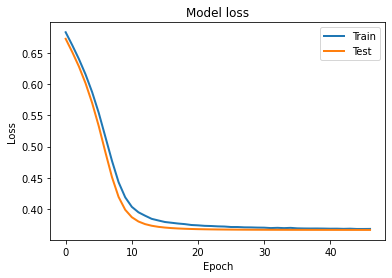

In [30]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

## Plot Reconstruction Error

In [31]:
X_test_predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})

204/204 [==============================] - 0s 1ms/step


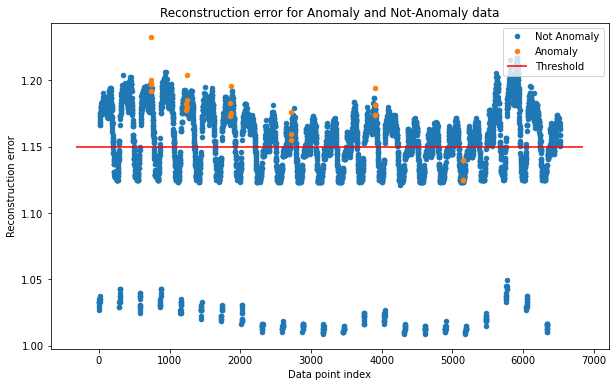

In [32]:
threshold_fixed = 1.15
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize = (10,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=4.5, linestyle='',
            label= "Anomaly" if name == 1 else "Not Anomaly")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend(loc = 'upper right')
plt.title("Reconstruction error for Anomaly and Not-Anomaly data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

## Plot Metrics

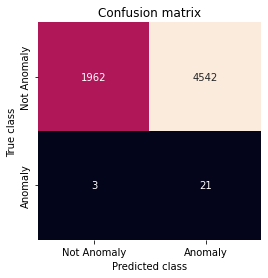

 F1-Score:  0.009156311314584697
 Recall:  0.875
 Precision:  0.0046022353714661405


In [33]:
threshold_fixed = 1.14
y_pred = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =y_pred
conf_matrix = confusion_matrix(error_df.True_class, y_pred)
# print(conf_matrix)
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cbar=False);
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" F1-Score: ",metrics.f1_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))

In [34]:
print(error_df.pred.value_counts(), "\n","--------------------------")
print("in percentage", "\n", "--------------------------")
print(error_df.pred.value_counts(normalize=True))

1    4563
0    1965
Name: pred, dtype: int64 
 --------------------------
in percentage 
 --------------------------
1    0.698989
0    0.301011
Name: pred, dtype: float64


# Conclusion